In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import math
import sys
sys.path.append("..")
import physics
sys.path.append("../..")
from spec.spectrum import *
import spec.spectools as spectools
import xsecs

In [3]:
class Rates(object):
  
    def __init__(self, E_spec, n, den=[1,1,1], dNdW=np.zeros((2,1)), rates=np.zeros(4)):
        self.energy = E_spec.eng[n]
        self.n = n
        self.dNdE = E_spec.dNdE[n]
        self.den = den
        self.rates = rates
        self.v = np.sqrt(2*np.array([E_spec.eng[n]])/physics.me)*physics.c 
        self.mult = self.den*self.v
        self.dNdW = np.zeros((2, self.n ))
    
    def ion_dNdW_calc_H(self): #uses new integration method
        '''Fills *self.dNdW[0,:]* with the discretized singly differential xsec in rate form
        '''
        eng_temp = E_spec.eng[0:self.n]
        ion_s_rates = xsecs.ionize_s_cs_H_2(self.energy, eng_temp)    #possible problem with np type
        self.dNdW[0] = ion_s_rates *self.mult[0]                      #dNdE? ;also, [0,:]?
        return self.dNdW
    
    def ion_rate_calc(self):
        '''Fills *self.rate[1:3]* vector by calculating total xsec and then converting to rate
        '''
        ion_rates = xsecs.ionize_cs(self.energy*np.ones(3),np.array([1,2,3]))*self.mult
        self.rates[1:4] = ion_rates
        return self.rates
    
    def heat_rate_calc(self, x_e, rs):
        '''Fills *self.rate[0]* vector with fraction going to heating
            x_e and rs...
        '''
        dE = xsecs.heating_dE(self.energy, x_e, rs, nH=physics.nH)
        delta_dNdE = np.zeros(len(E_spec.dNdE))
        np.put(delta_dNdE, self.n, self.dNdE)
        delta = Spectrum(E_spec.eng, delta_dNdE, rs)
        shift_delta_eng = E_spec.eng+dE
        delta.shift_eng(shift_delta_eng)
        delta.rebin(E_spec.eng)
        
        heating_frac = delta.dNdE[self.n]/self.dNdE
        self.rates[0] = 1-heating_frac #units? 
        return(self.rates)
    
    def E_loss(self):
        '''loss fraction
        '''
        E_loss_ion=13.6*self.rates[1]
        E_loss_heat=(E_spec.eng[self.n]-E_spec.eng[self.n-1])*self.rates[0]
        E_frac = E_loss_ion/E_loss_heat
        return(E_frac)
    
    def ion_int_calc(self):
        '''gives total ionization rate
        '''
        bin_width = get_log_bin_width(E_spec.eng[0:self.n])
        integ = 0
        for i in range(self.n):
            integ += self.dNdW[0,i-1]*bin_width[i]*E_spec.eng[i]
        return integ
        
        

In [47]:
def electron_low_e(E_spec, rs, ion_frac=[0.001,0.001,0.001], den=[1,1,1], dt=1 ,all_outputs=False):
   
    N = len(E_spec.eng)
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    
    R = np.zeros((2,N))
    R[1,0] = 1
    R[1,1] = 1
    R[1,2] = 1
    
    for n in range(3,N):
        e_rates = Rates(E_spec, n, den)
        e_rates.ion_rate_calc()
        e_rates.heat_rate_calc(ion_frac[0], rs)
        e_rates.ion_dNdW_calc_H() 
        
        delta_E_spec = np.ediff1d(E_spec.eng)[0:(n)] #bin widths
        
        discrete_dN_dEdt_i = e_rates.dNdW[0]
        
        h_init=np.zeros(n)
        h_init[n-2] = e_rates.rates[0]
        h_init[n-1] = 1 - e_rates.rates[0]
        discrete_dN_dEdt_h = h_init/delta_E_spec
        
        
        R_in = ((13.6*e_rates.rates[1]) + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            
        
        R_hn = ((e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1])) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            

        R[0,n] = R_in/(R_in+R_hn)
        R[1,n] = R_hn/(R_in+R_hn)
        
        if n == 400:
            print('energy')
            print(e_rates.energy)
            print('ion')
            print(13.6*e_rates.rates[1])
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]))
            print('heat')
            print(e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]))
        
        #R[0,n] = R_in
        #R[1,n] = R_hn
        
        #print(n, e_rates.energy,R_in,R_hn)
        #print(e_rates.energy*e_rates.rates[0], np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1]), np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]),np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) )
        
        
    return R
    

In [48]:
results_ion_frac_2 = electron_low_e(E_spec,10**9)

../../darkhistory/spec/spectools.py:30: RuntimeWarning: invalid value encountered in log
  log_bin_width_low = np.log(eng[1]) - np.log(eng[0])
../../darkhistory/spec/spectools.py:31: RuntimeWarning: invalid value encountered in log
  log_bin_width_upp = np.log(eng[-1]) - np.log(eng[-2])
../../darkhistory/spec/spectools.py:37: RuntimeWarning: invalid value encountered in log
  low_lim = np.exp(np.log(eng[0]) - log_bin_width_low / 2)
../../darkhistory/spec/spectools.py:38: RuntimeWarning: invalid value encountered in log
  upp_lim = np.exp(np.log(eng[-1]) + log_bin_width_upp / 2)
../spec/spectrum.py:690: RuntimeWarning: divide by zero encountered in true_divide
  new_dNdE = self.totN('bin')/(new_eng * new_log_bin_width)
../spec/spectrum.py:690: RuntimeWarning: invalid value encountered in true_divide
  new_dNdE = self.totN('bin')/(new_eng * new_log_bin_width)
../spec/spectrum.py:510: RuntimeWarning: invalid value encountered in multiply
  return dNdlogE * log_bin_width
../spec/spectrum.p

energy
1608.46948327
ion
5.03914398626e+13
1.46170525121e+12
1550.17271675
heat
58.2943659296
80591682.135
0.00240058933734


<h1>Testing specific spectra:</h1>

In [5]:
eng1 = np.logspace(0.,4.,num = 500)
#dNdE1 = np.logspace(0.,5.,num = 500)
dNdE1 = np.linspace(1, 100000, num=500)
rs=0
E_spec = Spectrum(eng1,dNdE1,rs)

In [6]:
%%capture
results_ion_frac_0 = electron_low_e(E_spec,10**9)

In [54]:
%%capture
results_ion_frac_1 = electron_low_e(E_spec,100)

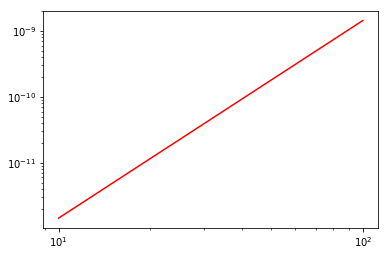

In [8]:
#heating_dE
ion_frac=[0.001,0.001,0.001]
den=[1,1,1]
n=10

x=np.linspace(10,100,num = n)
heat_dE=np.zeros((n,1))

for k,rs in enumerate(x):
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    heat_dE[k] = -xsecs.heating_dE(100, ion_frac[0], rs)

plt.plot(x,heat_dE, 'r')
plt.xscale('log')
plt.yscale('log')
plt.show()


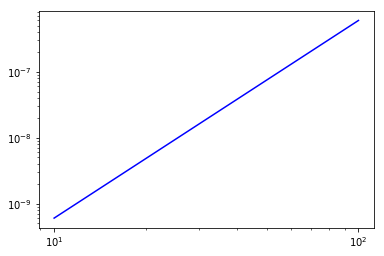

In [9]:
#heating Rates class
ion_frac=[0.001,0.001,0.001]
den=[1,1,1]
n=10


x=np.linspace(10,100,num = n)
rate=np.zeros((n,1))
for k,rs in enumerate(x):
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    e_rates_test = Rates(E_spec, n, den)
    e_rates_test.heat_rate_calc(ion_frac[0], rs)
    rate[k] = e_rates_test.rates[0]

plt.plot(x,rate, 'b')
plt.xscale('log')
plt.yscale('log')
plt.show()


[[  6.25977584e-12]
 [  5.00782067e-11]
 [  1.69013948e-10]
 [  4.00625653e-10]
 [  7.82471979e-10]
 [  1.35211158e-09]
 [  2.14710311e-09]
 [  3.20500523e-09]
 [  4.56337658e-09]
 [  6.25977584e-09]]


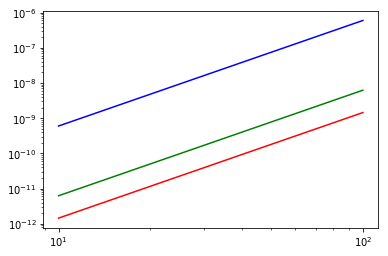

In [10]:
#ion Rates class
ion_frac=[0.001,0.001,0.001]
den=[1,1,1]
n=10

x=np.linspace(10,100,num = n)
rate_i=np.zeros((n,1))

for k,rs in enumerate(x):
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    e_rates_test = Rates(E_spec, 300, den)
    e_rates_test.ion_rate_calc()
        #e_rates_test.ion_dNdW_calc_H() 
        #print(e_rates_test.dNdW)
        #discrete_dN_dEdt_i = e_rates.dNdW[0]
    rate_i[k] = e_rates_test.rates[1]
    
print(rate_i)
plt.plot(x,rate_i, 'g')
plt.plot(x,rate, 'b')
plt.plot(x,heat_dE, 'r')
plt.xscale('log')
plt.yscale('log')
plt.show()



0

1

2

3

4

5

6

7

8

9


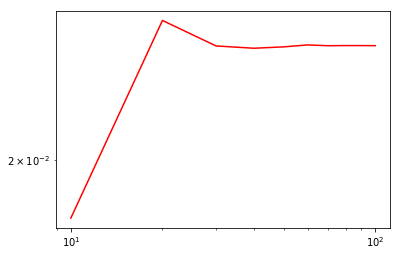

In [11]:
x=np.linspace(10,100,num = 10)
y=np.zeros((10,1))

for k,rs in enumerate(x):
    y[k] = electron_low_e(E_spec, rs)[1,300]
    print(k)

plt.plot(x,y, 'r')
plt.xscale('log')
plt.yscale('log')
plt.show()
#heat rate versus redshift

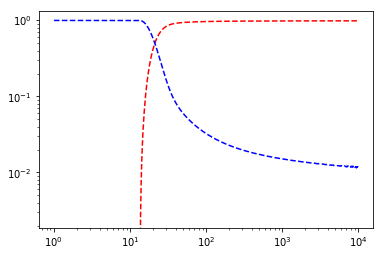

In [55]:
np.set_printoptions(threshold = np.nan)
#print(np.transpose([E_spec.eng, results_ion_frac_0[0,:],results_ion_frac_0[1,:]]))
#plt.plot(E_spec.eng, results_ion_frac_0[0,:], 'r')   #10**9
plt.plot(E_spec.eng, results_ion_frac_1[0,:], 'r--') #10**2
#plt.plot(E_spec.eng, results_ion_frac_0[1,:], 'b')
plt.plot(E_spec.eng, results_ion_frac_1[1,:], 'b--')
plt.xscale('log')
plt.yscale('log')
plt.show()

../../darkhistory/spec/spectools.py:30: RuntimeWarning: divide by zero encountered in log
  log_bin_width_low = np.log(eng[1]) - np.log(eng[0])
../../darkhistory/spec/spectools.py:37: RuntimeWarning: divide by zero encountered in log
  low_lim = np.exp(np.log(eng[0]) - log_bin_width_low / 2)
/Users/cannonvogel/Documents/GitHub/DarkHistory/darkhistory/electrons/xsecs.py:275: RuntimeWarning: divide by zero encountered in double_scalars
  return S/(B*(t+(u+1)))*((N_i/N-2)/(t+1)*(1/(w+1)+1/(t-w))*(2-N_i/N)*(1/(w+1)**2+1/(t-w)**2)+ numpy.log(t)/(N*(w+1))*df_dw) #cm^2/eV


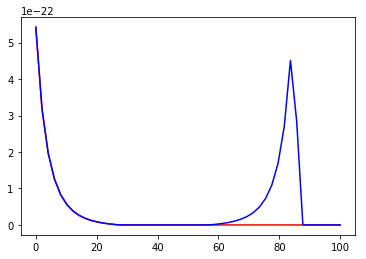

In [13]:
sec = np.linspace(0,100)
spec = xsecs.ionize_s_cs_H(100, sec)
spec2 = xsecs.ionize_s_cs_H_2(100, sec)

plt.plot(sec,spec, 'r')
plt.plot(sec,spec2, 'b')
plt.show()